I will attempt to write a generalized SMC with a graph computation network

In [15]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import numpy as np
import torch
torch.autograd.set_detect_anomaly(True)
import tqdm

In [17]:
def polynomial_potential(x, hl):
    """
    define a polynomial potential of the form:
    hl[1,0]*(x - hl[0,0])**(len(hl[0,:])) + hl[1,1]*(x - hl[0,1])**(len(hl[0,:]) - 1) + ...
    
    arguments
        x : torch.tensor (shape: (1))
            position of particle
        hl : torch.tensor (shape: (2,N))
            'hyper' latent variables; the first row is a set of 'horizontal' offsets and the second row is a set of scaling coefficients;
            N is the highest polynomial power of the energy equation
    """
    #check that the shape is appropriate
    hl_size = hl.size()
    x_size = x.size()
    assert hl_size[0] == 2
    
    power_vector = torch.tensor(range(1, hl_size[1] + 1)[::-1])
    differences = x - hl[0,:]
    
    energy = (hl[1,:]*differences.pow(power_vector)).sum()
    
    return energy

def polynomial_derivative(x, hl):
    """
    define the derivative of the polynomial potential
    
    arguments
        x : torch.tensor (shape: (1))
            position of particle
        hl : torch.tensor (shape: (2,N))
            'hyper' latent variables; the first row is a set of 'horizontal' offsets and the second row is a set of scaling coefficients;
            N is the highest polynomial power of the energy equation
    """
    #check that the shape is appropriate
    hl_size = hl.size()
    x_size = x.size()
    assert hl_size[0] == 2
    
    power_vector = torch.tensor(range(0, hl_size[1])[::-1])
    new_coeffs =  torch.tensor(range(1, hl_size[1] + 1)[::-1])
    differences = x - hl[0,:]
    
    der = (hl[1,:]*new_coeffs*differences.pow(power_vector)).sum()
    return der

def test_poly_der(x = torch.randn(1, requires_grad=True), hl = torch.randn(2, 5)):
    u = polynomial_potential(x, hl)
    u.backward()
    assert np.isclose(x.grad.item(), polynomial_derivative(x, hl).item())
    
test_poly_der()

def log_probability(potential):
    """
    generat a log unnormalized probability from a potential
    """
    return torch.exp(-potential)


In [18]:
def exponential_average(works, bootstrap_resamples=None):
    """
    conduct an exponential average for the free energy in the spirit of the Jarzynski Equality;
    
    arguments
        works : torch.tensor(shape : (1, N)))
            list of sum(-logG_ts)
        bootstrap_resamples : int, default None
            the number of bootstrap resamples to compute an error estimate of the free energy; 
            if None, error of zero will be returned
    returns
        free_energy : torch.tensor(float)
            free energy estimate
        stddev : torch.tensor(float)
            stddev of free energy estimator
    """
    logZ = torch.logsumexp(-works, 0) - torch.tensor(np.log(len(works)))
    
    mod_works = works.clone().detach()
    if bootstrap_resamples is not None:
        mean_statistics = []
        for bs in range(bootstrap_resamples):
            random_indices = np.random.choice(range(len(works)), len(works))
            subsample_stat = torch.tensor([mod_works[i] for i in random_indices])
            mean_statistic = torch.logsumexp(-subsample_stat, 0)
            mean_statistics.append(mean_statistic.item() - torch.tensor(np.log(len(works))))
        stddev = np.std(np.array(mean_statistics))
    else:
        stddev = 0.
    
    return -logZ, stddev
    

In [19]:
def log_gaussian_probability(x, mu, sigma):
    """
    return log(N(x|mu, sigma))
    
    arguments
        x : torch.tensor (shape : (1))
            Lebesgue support
        mu : torch.tensor (shape : (1))
            mean
        sigma : torch.tensor (shape : (1))
            standard_deviation     
    returns
        logp : torch.tensor (shape : (1))
           log probability measure 
    """
    import math
    log_unnorm_prob = -(x - mu)**2 / (2 * sigma**2)  
    
    lognorm = torch.log(sigma * torch.sqrt(torch.tensor(2*math.pi)))
    
    logp = log_unnorm_prob - lognorm
    return logp
    
    

In [20]:
def gaussian_proposal(mu, sigma):
    """
    conduct a gaussian proposal (i.e. x ~ N(mu, sigma)); asserts that mu and sigma are requires_grad==False
    
    arguments
        mu : torch.tensor (shape : (1))
            mean
        sigma : torch.tensor (shape : (1))
            standard_deviation 
    returns
        x : torch.tensor(shape : (1), grad_)
            returnable position
    """
    x = sigma * torch.randn(1) + mu
    return x
    

In [21]:
def EL_mu_sigma(x, potential, tau):
    """
    create mu and sigma vars for the euler-maruyama proposal
    mu = x - tau * grad(potential)(x)
    """
    try:
        x.grad.zero_()
    except:
        pass
    potential.backward()
    mu = x.clone().detach() - tau * x.grad
    sigma = torch.sqrt(2*tau)
    x.grad.zero_()
    return mu, sigma

def EL_mu_sigma_from_derivative(x, derivative, tau):
    mu = x - tau * derivative
    sigma = torch.sqrt(2*tau)
    return mu, sigma
    
    
    

In [22]:
a = torch.randn(3,3)
a[0]

tensor([-2.5892,  1.1238,  0.5918])

In [23]:
#we should be able to propagate now... let's see if that works
x = torch.tensor(0., requires_grad=True)
hl = torch.tensor([[0., 0.], [1., 0.]], requires_grad=False)
energy = polynomial_potential(x, hl)

## Vanilla Brownian Motion on a Polynomial potential

In [24]:
def vanilla_polynomial_sampler(x, hl, tau, num_steps):
    """
    run simple, vanilla Euler Maruyama proposals on a constant pdf
    """
    import tqdm
    positions = []
    assert x.requires_grad
    for i in tqdm.trange(num_steps):
        energy = polynomial_potential(x, hl)
        mu, sigma = EL_mu_sigma(x, energy, tau)
        mu_batch, sigma_batch = mu.detach(), sigma.detach()
        x = gaussian_proposal(mu_batch, sigma_batch)
        positions.append(x.numpy())
        x.requires_grad=True
    
    out = np.array(positions).flatten()
    return out
        
        

In [25]:
x = torch.tensor(0., requires_grad=True)
hl = torch.tensor([[0., 0.], [1., 0.]], requires_grad=False)
tau = torch.tensor(5e-2)
out_pos = vanilla_polynomial_sampler(x, hl, tau, num_steps=1000)

100%|██████████| 1000/1000 [00:02<00:00, 373.96it/s]


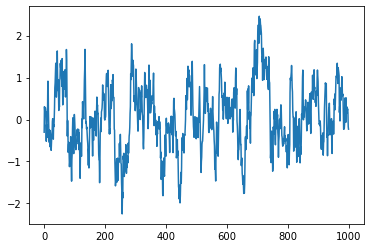

In [26]:
#plt.hist(out_pos)
plt.plot(out_pos)

## Annealed Importance Sampling between Gaussians

In the statistical literature, the geometric path for static models takes the form: $\gamma_t(dx) \equiv \mu (dx) \left( \frac{d \gamma}{d \mu}  (x)\right)^{\lambda_t}$ where $Z_t \equiv \gamma_t(\text{X})$ and $(\lambda_t)_{t \in [0:T]} \in [0,1]^{T+1}$.<br>
The Feynman-Kac path measure is recovered when we define potentials
$$
G_0(x_0) = 1 
\\
G_t(x_{t-1}) = \frac{\gamma_t(x_{t-1})}{\gamma_{t-1}(x_{t-1})}; t \in [1:T]
$$.
In this case, the normalizing constant $Z \equiv Z_T = \prod_{t=1}^{T} \left[ \frac{1}{N} \sum_{n=1}^N G_t(x_{t-1}^n) \right]$

For numerical stability, and for the sake of those who are restricted to thinking of things in terms of 'energy', we can say that $Z = \frac{1}{N} \sum_{n=1}^{N} \prod_{t=1}^{T} G_t(x_{t-1}^n)$ as long as particle ancestry is static. Interestingly, this is mathematically identical to the Jarzynski Equality, which says
$$
e^{-f} = \langle e^{-w} \rangle
$$
where $f = - \log Z$ and $w = -\log G_t(x_{t-1})$. <br>
Notice that we can also use the Crooks Fluctuation Theorem (CFT) (which implies the Jarzynski Equality), but it is worthy of mentioning that the CFT is just a specific case of the Feynman-Kac model (i.e. for static models). I will come back to this when I generalize Annealed Importance Sampling to the static model case.




For sanity purposes, I am going to plot the prior, the posterior, and a sequence of 98 intermediates...

In [27]:
def AIS(hl_prior, hl_posterior, num_particles, tau, num_target_distributions, starting_positions):
    """
    perform AIS with an euler-maruyama propagator on a polynomial potential with priors and posteriors defined accordingly; note, the propagator is not metropolized,
    so the target distributions are not exact, but should be close if tau is sufficiently small.
    
    arguments
        hl_prior : torch.tensor (shape: (2,N))
            the parameters defining the prior distribution
        hl_posterior : torch.tensor (shape: (2,N))
            the parameters defining the posterior distribution
        num_particles : int
            number of particles to propagate
        tau : torch.tensor (float)
            tau of euler-maruyama
        num_target_distributions : int
            number of target distributions (including prior and posterior)
        starting_positions : torch.tensor (shape: (1,N))
            starting positions of the propagator (assumed to be distributed according to the prior)
    
    returns
        positions : torch.tensor (shape: (1,N))
            final positions of the particles
        works : np.ndarray (shape (num_particles, num_target_distributions))
            array of incremental works of the particles
            take np.cumsum(works, axis=1) for array of cumulative works
        
    """
    works = np.zeros((num_particles, num_target_distributions)) #rows = num_particles, cols = num_target_distributions
    positions = starting_positions.clone().detach()
    
    #define a previous work tensor so that incremental works can be computed without having to recompute previous energy
    previous_energies = torch.tensor([polynomial_potential(q, hl_prior) for q in positions])
    
    #let's do this without presuming we can take grad and hardcode the whole process
    for particle_idx in tqdm.trange(len(positions)):
        x = positions[particle_idx]
        for lambda_idx, _lambda in enumerate(torch.tensor(np.linspace(0., 1., num_target_distributions)[1:])):
            old_energy = polynomial_potential(x, hl_prior) #prior energy
            new_energy = polynomial_potential(x, hl_posterior) #posterior energy
            geometric_energy_increment = (1. - _lambda)*old_energy + _lambda * new_energy #hybrid_geometric_energy
            if lambda_idx == num_target_distributions - 1: #just a sanity check
                assert new_energy.item() == geometric_energy_increment.item()
            
            works[particle_idx, lambda_idx+1] = geometric_energy_increment - previous_energies[particle_idx] #compute incremental work
            previous_energies[particle_idx] = geometric_energy_increment #set the previous energy to the new updated work
            
            #propagate
            old_derivative, new_derivative = polynomial_derivative(x, hl_prior), polynomial_derivative(x, hl_posterior)
            hybrid_derivative = (1. - _lambda)*old_derivative + _lambda * new_derivative
            mu, sigma = EL_mu_sigma_from_derivative(x, hybrid_derivative, tau) #take derivative w.r.t. geometric energy increment
            x = gaussian_proposal(mu, sigma)
            
            #add a consideration for the 'shadow work' here... (i.e. the ratio of proposals)
    
    return positions, works
    

Text(0, 0.5, '$p(x)$')

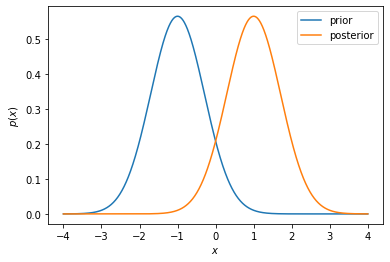

In [28]:
hl_prior = torch.tensor([[-1., 0.], [1., 0.]], requires_grad=False)
hl_posterior = torch.tensor([[1., 0.], [1., 0.]], requires_grad=False)
mu0, mu1 = torch.tensor(-1), torch.tensor(1)
sigma0, sigma1 = torch.tensor(1./np.sqrt(2)), torch.tensor(1./np.sqrt(2))
xs = np.linspace(-4, 4, 1000)
plt.plot(xs, [torch.exp(log_gaussian_probability(x, mu0, sigma0)) for x in torch.tensor(xs)], label = f"prior")
plt.plot(xs, [torch.exp(log_gaussian_probability(x, mu1, sigma1)) for x in torch.tensor(xs)], label = f"posterior")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$p(x)$")

In [29]:
num_particles = 100
from pymbar.bar import BAR
hl_prior = torch.tensor([[-1., 0.], [1., 0.]], requires_grad=False)
hl_posterior = torch.tensor([[1., 0.], [1., 0.]], requires_grad=False)
starting_positions = sigma0*torch.randn(num_particles)-1
ending_positions = sigma1*torch.randn(num_particles)+1
forward_positions, forward_works = AIS(hl_prior, hl_posterior, num_particles=num_particles, tau=torch.tensor(1e-2), num_target_distributions=10, starting_positions = starting_positions)
backward_positions, backward_works = AIS(hl_posterior, hl_prior, num_particles=num_particles, tau=torch.tensor(1e-2), num_target_distributions=10, starting_positions = ending_positions)
forward_cum_works = np.cumsum(forward_works, axis=1)
backward_cum_works = np.cumsum(backward_works, axis=1)
df, ddf = BAR(forward_cum_works[:,-1], backward_cum_works[:,-1])
print(df, ddf)

100%|██████████| 100/100 [00:00<00:00, 437.53it/s]

0.33569673180047277 0.21051347073147678


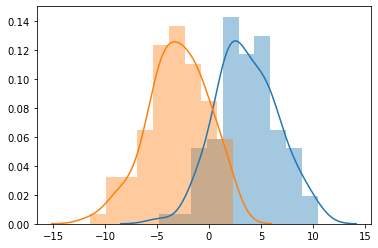

In [30]:
sns.distplot(forward_cum_works[:,-1])
sns.distplot(-backward_cum_works[:,-1])

So, it looks like we are able to recapitulate appropriate results (the free energy should be zero);<br>
we can also do this in the backward direction and use the maximum likelihood measure  (known as BAR), but i am not going to anneal in the backward directions since this seems to work rather well

The next thing I am going to do is write the generalized SMC algorithm (without resampling) with the _explicit_ $G_0$ and $G_t$ potential in terms of the Feynman-Kac model so that we can perhaps adapt it slightly and perform variational SMC on a static model.

A few notes on the following function:
- it should be clear at this point that we don't need to be able to take the derivative of any particle weights w.r.t. the particle position; the particle position is only `requires_grad=True` when it is explicitly invoked for a force computation (i.e. to conduct an Euler-Maruyama proposal)
- each $G_t$ potential, or incremental weight, should be appended to a list so that we _always_ have direct ability to manipulate the variable (if we modify a term)


In [31]:
def no_resample_generalized_smc(hls_targets, hls_M, hls_L, num_particles, taus_L, taus_M, positions):
    """
    in the interest of experimenting with the current capabilities of pytorchy computation graphs, i have a
    generalized smc method that _should_ be compatible with variational SMC, but does not resample.
    the reason i am doing this right now is that i want to be able to extend this bidirectionally and use an MLE estimator
    for the free energy, but it is not clear to me right now how to do that with resampling.
    
    Later, i will hopefully put this all together in a single pytorchy SMC class
    
    arguments
        hls_targets : list(torch.tensor (shape: (2,target_i))) of length num_distributions 
            the parameters defining sequence of distributions and 
        hls_M : list(torch.tensor (shape : (2, N_M))) of length (num_distributions-1)
            parameters defining invariant target distribution for M_t
        hls_L : list(torch.tensor (shape : (2, N_M))) of length (num_distributions-1)
            parameters defining invariant target distribution for M_t  
        num_particles : int
            number of particles to propagate
        taus_L : list(torch.tensor(float))
            taus of euler-maruyama backward kernels
        taus_M : list(torch.tensor (float)))
            taus of euler-maruyama forward kernels
        positions : torch.tensor (shape: (1,N))
            starting positions of the propagator (assumed to be distributed according to the prior)
    
    returns
        logged_positions : torch.tensor (shape: (N, len(taus_L + 1))
            final positions of the particles
        log_weights : list (shape (num_particles, 1))
            array of cumulative log_weights of particles
    
    NOTE: 
        - L_ts and corresponding taus_L are in ascending order [from 0 to T-1]; taus_L follow
        - M_ts and corresponding taus_M are in ascending order [from 1 to T]; taus_M follow
        - the hls_targets are in ascending order from [0 to T]
        - the only _real_ restriction is that hl_targets[-1] corresponds to the posterior
    """
    
    #some check assertions; the length of targets is one greater than the length of Ms, Ls
    assert len(hls_targets) == len(hls_M) + 1
    assert len(hls_M) == len(hls_L)
    assert len(taus_M) == len(taus_L)
    assert len(taus_M) == len(hls_M)
    
    
    #NOTE : for static models, \eta_0 and mu_0 (the pdfs of the first FK path measure and the Markov Chain Law initial pdf)
    #       are sampled from the same pdf, so the log G_0 = 0. (per usual)
    
    #this time, we'll just run the algorithm independently for each particle; maybe it will save time 
    log_weights = torch.zeros(len(positions))
    logged_positions = torch.zeros(len(positions), len(hls_targets))
    logged_positions[:,0] = positions
    
    for particle_idx in tqdm.trange(len(positions)): #run the Markov Chain for each particle
        old_position = logged_positions[particle_idx,0]
        cumulative_logGs = torch.zeros(len(hls_targets)-1)
        for t in range(1, len(hls_targets)): #we do iteration from t=1 to T
            gamma_new = hls_targets[t] #pull current target params
            gamma_old = hls_targets[t-1] #pull previous target params
            L_params, L_tau = hls_L[t-1], taus_L[t-1] #because index is one less
            M_params, M_tau = hls_M[t-1], taus_M[t-1] #because index is one less
            
            #propagate
            new_position = SMC_propagation(old_position, M_params, M_tau)
            logged_positions[particle_idx, t] = new_position
            
            #compute logG_t
            logG = compute_logG(hl_L = L_params, 
                                hl_M = M_params, 
                                hl_gamma_old = gamma_old, 
                                hl_gamma_new = gamma_new, 
                                tau_L = L_tau, 
                                tau_M = M_tau, 
                                old_pos = old_position, 
                                new_pos = new_position)
            
            cumulative_logGs[t-1] = logG
            old_position = new_position
            
        log_weights[particle_idx] = cumulative_logGs.sum()

    return logged_positions, log_weights
            
    

In [32]:
def compute_logG(hl_L, hl_M, hl_gamma_old, hl_gamma_new, tau_L, tau_M, old_pos, new_pos):
    """
    given hl_L, hl_M, hl_gamma_old, hl_gamma_new, tau_L, tau_M, old, new positions,
    compute a logG;
    G_t = frac{\gamma_t(dx_t) L_{t-1}(x_t, dx_{t-1})}{\gamma_{t-1}(dx_{t-1}) M_t(x_{t-1}, dx_t)}
    
    arguments
        hl_L : torch.tensor (shape : (2, N_L))
            parameters defining invariant target distribution for L_{t-1}
        hl_M : torch.tensor (shape : (2, N_M))
            parameters defining invariant target distribution for M_t
        hl_gamma_old : torch.tensor (shape : (2, N_gamma_old))
            parameters defining invariant target for \gamma_t-1
        hl_gamma_new : torch.tensor (shape : (2, N_gamma_new))
        tau_L : torch.tensor(float)
            tau of the backward kernel L_{t-1}
        tau_M : torch.tensor(float)
            tau of the forward kernel M_t
        old_pos : torch.tensor(float)
            old position
        new_pos : torch.tensor(float)
            new position
    returns
        logG : torch.tensor(float)
            logG_t
    """
    #log_M
    M_derivative = polynomial_derivative(old_pos, hl_M)
    mu_M, sigma_M = EL_mu_sigma_from_derivative(old_pos, M_derivative, tau_M)
    log_M = log_gaussian_probability(new_pos, mu_M, sigma_M) #compute log_M

    #log_L
    L_derivative = polynomial_derivative(new_pos, hl_L) #compute -force of L backward
    mu_L, sigma_L = EL_mu_sigma_from_derivative(new_pos, L_derivative, tau_L) # compute backward parameters
    log_L = log_gaussian_probability(old_pos, mu_L, sigma_L) #compute log_L
    
    #logG = log(\gamma_t(x_t)) + log(L_{t-1}(x_t, {dx_{t-1}})) - [ log(\gamma_{t-1}(x_{t-1})) + log(M_t(x_{t-1}, dx_t))  ]
    logG = (-polynomial_potential(new_pos, hl_gamma_new)
            + log_L
            - (-polynomial_potential(old_pos, hl_gamma_old)
               + log_M)
           )
    return logG
    
    
def SMC_propagation(position, hl_M, tau_M):
    """
    conduct a single iteration of SMC for a single particle
    for static models, G_t = frac{\gamma_t(dx_t) L_{t-1}(x_t, dx_{t-1})}{\gamma_{t-1}(dx_{t-1}) M_t(x_{t-1}, dx_t)}
    
    arguments
        position : torch.tensor(float) (requires_grad=False)
            x_{t-1}
        hl_M : torch.tensor (shape : (2, N_M))
            parameters defining invariant target distribution for M_t
        tau_M : torch.tensor(float)
            tau of the forward kernel M_t
    
    returns
        position : torch.tensor(float) (requires_grad=False)
            new position after M_t propagation
    """
    #make a proposal with M_t from x_{t-1}
    old_position = position.clone().detach() #equip the starting position
    M_derivative = polynomial_derivative(position.clone().detach(), hl_M.clone().detach()) #compute the -force for the forward transition kernel
    mu_M, sigma_M = EL_mu_sigma_from_derivative(old_position, M_derivative, tau_M.clone().detach()) #compute mu and sigma for the forward transition kernel
    new_position = gaussian_proposal(mu_M, sigma_M) #make a proposal given the forward transition kernel parameters
    return new_position

In [33]:
def generate_AIS_params(hls_prior, hls_posterior, num_distributions):
    """
    generate hls_targets sequences, hls_M, hls_L with a geometric annealing protocol
    
    arguments
        hls_prior : list(torch.tensor(shape : (2, N)))
            the prior parameters for the potential
        hls_posterior : list(torch.tensor(shape : (2, N)))
            the posterior parameters for the potential
        num_distributions : int
            the number of target distributions (including prior and posterior); must be >=2
    
    returns 
        hls_M : list(torch.tensor (shape : (2, N_M))) of length (num_distributions-1)
            parameters defining invariant target distribution for M_t
        hls_M : list(torch.tensor (shape : (2, N_M))) of length (num_distributions-1)
            parameters defining invariant target distribution for M_t
        hls_target : list(torch.tensor (shape: (2,target_i))) of length num_distributions 
            the parameters defining sequence of distributions and 
    """
    assert num_distributions >= 2
    assert hls_prior.requires_grad==False
    assert hls_posterior.requires_grad==False
    
    hls_target = [hls_prior.clone().detach().requires_grad_(True)]
                 
    hls_M, hls_L = [], []
    _lambdas = np.linspace(0., 1., num_distributions)
    for index, _lambda in enumerate(_lambdas[1:]):
        hl_target = (_lambda * hls_posterior + (1. - _lambda) * hls_prior).clone().detach().requires_grad_(True)
        hl_M = hl_target.clone().detach().requires_grad_(True) # the hl_M parameters target the same target distribution
        hl_L = hl_target.clone().detach() # the hl_L parameters target the same target distribution
        
        #add to the lists
        hls_target.append(hl_target)
        hls_M.append(hl_M)
        hls_L.append(hl_L)
    
    return hls_M, hls_L, hls_target
    

In [34]:
num_particles, num_distributions = 100, 10
hls_prior = torch.tensor([[-1., 0.], [1., 0.]])
hls_posterior = torch.tensor([[1., 0.], [1., 0.]])
mean0, mean1 = -1., 1.
sigma0, sigma1 = torch.tensor(1./np.sqrt(2)), torch.tensor(1./np.sqrt(2))
taus_L = [torch.tensor(1e-2, requires_grad=False) for _ in range(num_distributions - 1)]
taus_M = [torch.tensor(1e-2, requires_grad=True) for _ in range(num_distributions - 1)]
forward_starting_positions = sigma0*torch.randn(num_particles) + mean0
backward_starting_positions = sigma1*torch.randn(num_particles) + mean1
forward_hls_M, forward_hls_L, forward_hls_targets = generate_AIS_params(hls_prior, 
                                                                        hls_posterior, 
                                                                        num_distributions=num_distributions)
backward_hls_M, backward_hls_L, backward_hls_targets = generate_AIS_params(hls_posterior, 
                                                                        hls_prior, 
                                                                        num_distributions=num_distributions)
forward_positions, forward_log_weights = no_resample_generalized_smc(forward_hls_targets, 
                                                                     forward_hls_M, 
                                                                     forward_hls_L, 
                                                                     num_particles, 
                                                                     taus_L, 
                                                                     taus_M, 
                                                                     forward_starting_positions)
backward_positions, backward_log_weights = no_resample_generalized_smc(backward_hls_targets, 
                                                                     backward_hls_M, 
                                                                     backward_hls_L, 
                                                                     num_particles, 
                                                                     taus_L, 
                                                                     taus_M, 
                                                                     backward_starting_positions)


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


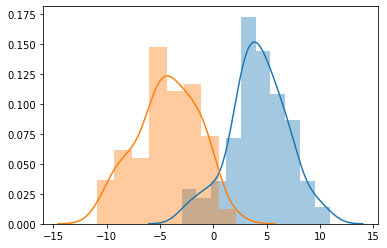

In [35]:
sns.distplot(-forward_log_weights.clone().detach().numpy())
sns.distplot(backward_log_weights.clone().detach().numpy())

In [ ]:
min(-forward_log_weights.clone().detach().numpy())

so it looks like we can recover the AIS result relatively well...

In [ ]:
hls_M, taus_M, logZs, hls_M_rec, taus_M_rec, log_weights_recorder = vSMC_optimizer(forward_log_weights,
                   forward_hls_targets,
                   forward_hls_M, 
                   taus_M, 
                   forward_hls_L, 
                   taus_L, 
                   forward_positions, 
                   epochs=10, 
                   learning_rate = 5e-4)

In [ ]:
forward_starting_positions = sigma0*torch.randn(num_particles) + mean0
new_forward_positions, new_forward_log_weights = no_resample_generalized_smc(forward_hls_targets, 
                                                                     hls_M, 
                                                                     forward_hls_L, 
                                                                     num_particles, 
                                                                     taus_L, 
                                                                     taus_M, 
                                                                     forward_starting_positions)

In [ ]:
sns.distplot(-new_forward_log_weights.clone().detach().numpy())

In [ ]:
min(-new_forward_log_weights.clone().detach().numpy())

In [ ]:
sns.distplot(new_forward_positions.numpy()[:,0])
sns.distplot(new_forward_positions.numpy()[:,-1])

In [ ]:
def vSMC_optimizer(log_weights,
                   hls_targets,
                   hls_M, 
                   taus_M, 
                   hls_L, 
                   taus_L, 
                   logged_positions, 
                   epochs, 
                   learning_rate = 1e-6):
    """
    in the spirit of variational sequential monte carlo, we can maximize logZ w.r.t. the parameters defining logM
    
    arguments
        log_weights : torch.tensor(shape : 1)
            log weights s.t. logZ = logsumexp(log_weights) - log(N) where N is the number of weights
        hls_targets : torch.tensor (shape: (2,target_i, Q)))
            the parameters defining sequence of distributions and 
        hls_M : torch.tensor (shape : (2, N_M, Q-1)))
            parameters defining invariant target distribution for M_t
        taus_M : torch.tensor (shape:Q-1))
            taus of euler-maruyama forward kernels
        hls_L : torch.tensor (shape : (2, N_M, Q-1)))
            parameters defining invariant target distribution for M_t
        taus_L : torch.tensor (shape:Q-1))
            taus of euler-maruyama forward kernels
        logged_positions : torch.tensor(shape : (num_particles, Q))
        epochs : int
            number of minimizations to do
        learning_rate : float
            rate of learning
    
    returns 
        hls_M_new : list(torch.tensor (shape : (2, N_M))) of length (num_distributions-1)
            parameters defining invariant target distribution for M_t (requires_grad=True)
        taus_M : list(torch.tensor (float))
            taus of euler-maruyama forward kernels (requires_grad=True)
    
    """
    log_weights_copy = log_weights.clone().detach()
    log_weights_copy_copy = recompute_log_weights([i.clone().detach() for i in hls_targets],
                          [i.clone().detach() for i in hls_M], 
                          [i.clone().detach() for i in taus_M], 
                          [i.clone().detach() for i in hls_L], 
                          [i.clone().detach() for i in taus_L], 
                          logged_positions)
    assert np.allclose(log_weights_copy.numpy(), log_weights_copy_copy.numpy())
    logZs = []
    hls_M_recorder, taus_M_recorder = [[i.clone().detach().numpy() for i in hls_M]], [[i.clone().detach().numpy() for i in taus_M]]
    log_weights_recorder = [log_weights_copy]
    
    for iteration in tqdm.trange(epochs):
        if iteration==0:
            #log_weights is already defined
            pass
        else:
            log_weights = recompute_log_weights(hls_targets,
                          hls_M, 
                          taus_M, 
                          hls_L, 
                          taus_L, 
                          logged_positions)
            
            
        logZ = torch.logsumexp(log_weights, 0) #we want to maximize this...
        logZs.append(logZ)
        print(f"logZ : {logZ}")
        
        logZ.backward()
#         print(f"grads hls_M: {[i.grad for i in hls_M]}")
#         print(f"grads taus: {[i.grad for i in taus_M]}")
        #print(learning_rate * taus_M[0].grad)
        for i in range(len(hls_M)):
            with torch.no_grad():
                taus_M[i] += torch.clamp(learning_rate * taus_M[i].grad, min=1e-6, max = 1e6)
                #hls_M[i] += learning_rate * hls_M[i].grad

                taus_M[i].grad.zero_()
                hls_M[i].grad.zero_()
        hls_M_recorder.append([i.clone().detach().numpy() for i in hls_M])
        taus_M_recorder.append([i.clone().detach().numpy() for i in taus_M])
        log_weights_recorder.append([i.clone().detach() for i in log_weights])
    
    return hls_M, taus_M, logZs, hls_M_recorder, taus_M_recorder, log_weights_recorder
            
            
def recompute_log_weights(hls_targets,
                          hls_M, 
                          taus_M, 
                          hls_L, 
                          taus_L, 
                          logged_positions):
    """
    
    """
    log_weights = log_weights = torch.zeros(logged_positions.size()[0])
    for particle_index in range(logged_positions.size()[0]):
        #
        cumulative_logGs = torch.zeros(len(hls_targets)-1)
        for t in range(1, len(hls_targets)): #we do iteration from t=1 to T
            gamma_new = hls_targets[t] #pull current target params
            gamma_old = hls_targets[t-1] #pull previous target params
            L_params, L_tau = hls_L[t-1], taus_L[t-1] #because index is one less
            M_params, M_tau = hls_M[t-1], taus_M[t-1] #because index is one less
        
            #compute logG_t
            logG = compute_logG(hl_L = L_params, 
                                hl_M = M_params, 
                                hl_gamma_old = gamma_old, 
                                hl_gamma_new = gamma_new, 
                                tau_L = L_tau, 
                                tau_M = M_tau, 
                                old_pos = logged_positions[particle_index, t-1], 
                                new_pos = logged_positions[particle_index, t])
            
            cumulative_logGs[t-1] = logG
        log_weights[particle_index] = cumulative_logGs.sum()
    return log_weights
            
            